### Skip to below...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Reference: https://gist.github.com/josephyooo/560130e1977c64e8e615ff133b457755
def calculate_confusion_matrix(model, dataloader, device, num_classes):
    matrix = np.zeros((num_classes, num_classes))

    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            pred_labels = torch.argmax(outputs, axis=1)

            for i in range(labels.shape[0]):
                    matrix[labels[i], pred_labels[i]] += 1


    matrix = matrix / matrix.sum(axis=1, keepdims=True)

    return matrix

def display_confusion_matrix(confusion_matrix, num_classes, class_names=None, log_scale=False):
    fig, ax = plt.subplots()

    ax.set_title('Confusion Matrix')
    fig.set_size_inches(10, 6)

    if log_scale:
        cax = ax.matshow(confusion_matrix)
    else:
        import copy
        import matplotlib
        my_cmap = copy.copy(matplotlib.colormaps['grey']) # copy the default cmap
        my_cmap.set_bad((0,0,0))
        cax = ax.matshow(confusion_matrix, norm=matplotlib.colors.LogNorm(), interpolation='nearest', cmap=my_cmap)

    cbar = fig.colorbar(cax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    if class_names:
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
    ax.xaxis.set_ticks_position('bottom')

    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')

    plt.show()

### Import and select your model below
A confusion matrix will be calculated against all data and displayed.

/home/jo-wubuntu/.cache/pypoetry/virtualenvs/hair-deisease-cnn-project-sPLV6DJP-py3.10/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


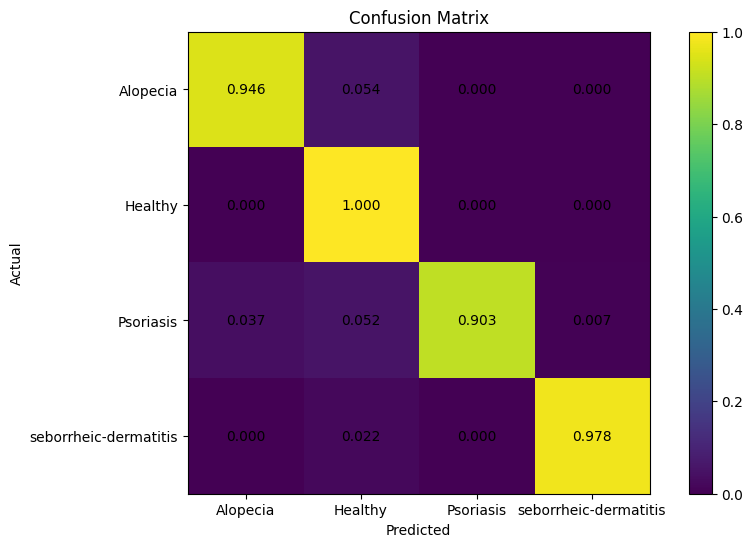

In [2]:
if __name__ == "__main__":
    import os
    import re

    from data_prep import DermNet, get_dataloaders
    from googlenet_scalp import GoogLeNet_Scalp

    # select model here
    model = GoogLeNet_Scalp

    # setup data and model
    dataset = DermNet()
    dataloader, _ = get_dataloaders(dataset=dataset, split=0, shuffle=False)
    num_classes = len(dataset.classes)

    # get and set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model(device, num_classes)

    # infer weights file name from model class name
    weight_files = os.listdir('weights')
    target_weight = model.__class__.__name__.lower()
    r = re.compile(f'{target_weight}.+')
    weight_files = list(filter(r.match, weight_files))
    if weight_files:
        target_weight = weight_files[0] # greedy search
        model.load_state_dict(torch.load(f'weights/{target_weight}'))
    else:
        print(f'No weights found for {target_weight}. Continuing with random weights.')

    # calculate and display confusion matrix
    class_names = dataset.classes
    class_names = [class_names[x][:-9] for x in range(num_classes)]

    confusion_matrix = calculate_confusion_matrix(model, dataloader, device, num_classes)
    display_confusion_matrix(confusion_matrix, num_classes, class_names=class_names, log_scale=True)